In [426]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [427]:
path_to_YKD_unburned = '/home/amullen/Lake-Model-Data/data/YKD/in_situ/US-YK2_HH_201907152200_202409010000.csv'
path_to_YKD_burned = '/home/amullen/Lake-Model-Data/data/YKD/in_situ/US-YK1_HH_201909281700_202212312330.csv'
path_to_YKD_base = '/home/amullen/Lake-Model-Data/data/YKD/in_situ/YKD_Weather_Composite.xlsx'
path_to_ERA5 = '/home/amullen/Lake-Model-Data/data/YKD/in_situ/YKD_two_ponds_LAKE_YKD_two_ponds_transient_ERA5.dat'

In [428]:
pi_180= np.pi/180

In [429]:
inputs_unburned = pd.read_csv(path_to_YKD_unburned, parse_dates=['TIMESTAMP_END'])[['TIMESTAMP_END', 'TA', 'PA', 'RH', 'VPD', 'P', 'LW_IN', 'SW_IN', 'WS', 'WD']]
inputs_unburned = inputs_unburned.replace(-9999, np.nan)
inputs_unburned['date'] = pd.to_datetime(inputs_unburned['TIMESTAMP_END'].dt.date)

inputs_unburned = inputs_unburned.groupby(by='date').aggregate({
                                                'TA': 'mean', #in C
                                                'PA': 'mean', #in kpa
                                                'RH': 'mean', #in %
                                                'VPD': 'mean',
                                                'LW_IN': 'mean', #W/m2
                                                'SW_IN': 'mean', #W/m2
                                                'WS': 'mean', #m/s
                                                'WD': 'mean', #degrees
                                                'P': lambda x: x.sum(skipna=False), #mm
                                                }).reset_index()

#initial unit conversion and qc
inputs_unburned['TA'] = inputs_unburned['TA'] + 273.15 # C to K
inputs_unburned['PA'] = inputs_unburned['PA'] * 1000 # kPa to Pa
inputs_unburned.loc[inputs_unburned['RH']>=100, 'RH'] = 99 #
inputs_unburned['Precip_intensity_ms-1'] = (inputs_unburned['P']/1000)/86400 #mm/d to m/s

inputs_unburned.loc[inputs_unburned['WD']==360, 'WD'] = 0
inputs_unburned['Uspeed'] = -inputs_unburned['WS']*np.cos(inputs_unburned['WD']*pi_180)
inputs_unburned['Vspeed'] = -inputs_unburned['WS']*np.sin(inputs_unburned['WD']*pi_180)



In [430]:
inputs_burned = pd.read_csv(path_to_YKD_burned, parse_dates=['TIMESTAMP_END'])[['TIMESTAMP_END', 'TA', 'PA', 'RH', 'VPD', 'P', 'LW_IN', 'SW_IN', 'WS', 'WD']]
inputs_burned = inputs_burned.replace(-9999, np.nan)
inputs_burned['date'] = pd.to_datetime(inputs_burned['TIMESTAMP_END'].dt.date)

inputs_burned = inputs_burned.groupby(by='date').aggregate({
                                                'TA': 'mean', #in C
                                                'PA': 'mean', #in kpa
                                                'RH': 'mean', #in %
                                                'VPD': 'mean',
                                                'LW_IN': 'mean', #W/m2
                                                'SW_IN': 'mean', #W/m2
                                                'WS': 'mean', #m/s
                                                'WD': 'mean', #degrees
                                                'P': lambda x: x.sum(skipna=False), #mm
                                                }).reset_index()

#initial unit conversion and qc
inputs_burned['TA'] = inputs_burned['TA'] + 273.15 # C to K
inputs_burned['PA'] = inputs_burned['PA'] * 1000 # kPa to Pa
inputs_burned.loc[inputs_burned['RH']>=100, 'RH'] = 99 #
inputs_burned['Precip_intensity_ms-1'] = (inputs_burned['P']/1000)/86400 #mm/d to m/s

inputs_burned.loc[inputs_burned['WD']==360, 'WD'] = 0
inputs_burned['Uspeed'] = -inputs_burned['WS']*np.cos(inputs_burned['WD']*pi_180)
inputs_burned['Vspeed'] = -inputs_burned['WS']*np.sin(inputs_burned['WD']*pi_180)

In [431]:
inputs_base = pd.read_excel(path_to_YKD_base, parse_dates=['Date']).rename(columns={'Date':'date', 
                                                                                    'Air_Temp':'TA', 
                                                                                    'Pressure':'PA',
                                                                                    'Wind_Speed':'WS',
                                                                                    'Wind_Direction':'WD',
                                                                                    'Precipitation':'P'})
inputs_base = inputs_base.groupby(by='date').aggregate({
                                                'TA': 'mean', #in C
                                                'PA': 'mean', #in kpa
                                                'RH': 'mean', #in %
                                                'WS': 'mean', #m/s
                                                'WD': 'mean', #degrees
                                                'P': lambda x: x.sum(skipna=False), #mm
                                                }).reset_index()
inputs_base['TA'] = inputs_base['TA'] + 273.15 # C to K
inputs_base['PA'] = inputs_base['PA'] * 100 # hPa/mbar to Pa
inputs_base.loc[inputs_base['RH']>=100, 'RH'] = 99 #
inputs_base['Precip_intensity_ms-1'] = (inputs_base['P']/1000)/86400

inputs_base.loc[inputs_base['WD']==360, 'WD'] = 0
inputs_base['Uspeed'] = -inputs_base['WS']*np.cos(inputs_base['WD']*pi_180)
inputs_base['Vspeed'] = -inputs_base['WS']*np.sin(inputs_base['WD']*pi_180)

In [432]:
def calc_mr(temp, pres, rh):
    """Calculates mixing ratio (kg/kg) based on temp (K), Pressure (Pa), and RH (%)

    Args:
        temp (arraylike, numeric): temperature in Kelvin
        pres (arraylike, numeric): Air pressure in Pa
        rh (arraylike, numeric): Relative humidity in percent

    Returns:
         (arraylike, numeric): mixing ratio (kg water / kg air)
    """ 
    
    temp = temp-273.15
    mr=[]
    
    for i, temp in enumerate(temp):
        if temp>0:
            pws=610.94*np.exp(1)**(17.625*temp/(temp+243.04))
        else:
            pws=611.21*np.exp(1)**(22.587*temp/(temp+273.86))
        
        pw = (pws*rh[i])/100
        
        mr.append(0.62198*pw/(pres[i] - pw))
    return mr

In [433]:
# calculate mixing ratio
inputs_burned['RH (kg/kg)'] = calc_mr(inputs_burned['TA'], inputs_burned['PA'], inputs_burned['RH'])
inputs_unburned['RH (kg/kg)'] = calc_mr(inputs_unburned['TA'], inputs_unburned['PA'], inputs_unburned['RH'])
inputs_base['RH (kg/kg)'] = calc_mr(inputs_base['TA'], inputs_base['PA'], inputs_base['RH'])


In [434]:
#some filtering
inputs_unburned.loc[np.abs(inputs_unburned['PA']-inputs_unburned['PA'].mean())>4*inputs_unburned['PA'].std(), 'PA'] = np.nan
inputs_base.loc[(inputs_base['Uspeed']==0) & (inputs_base['Vspeed']==0), 'Uspeed'] = np.nan
inputs_base.loc[(inputs_base['Uspeed']==0) & (inputs_base['Vspeed']==0), 'Vspeed'] = np.nan

In [435]:
df_era5 = pd.read_csv(path_to_ERA5)
df_era5['date'] = pd.to_datetime(df_era5[['Year', 'Month', 'Day']])


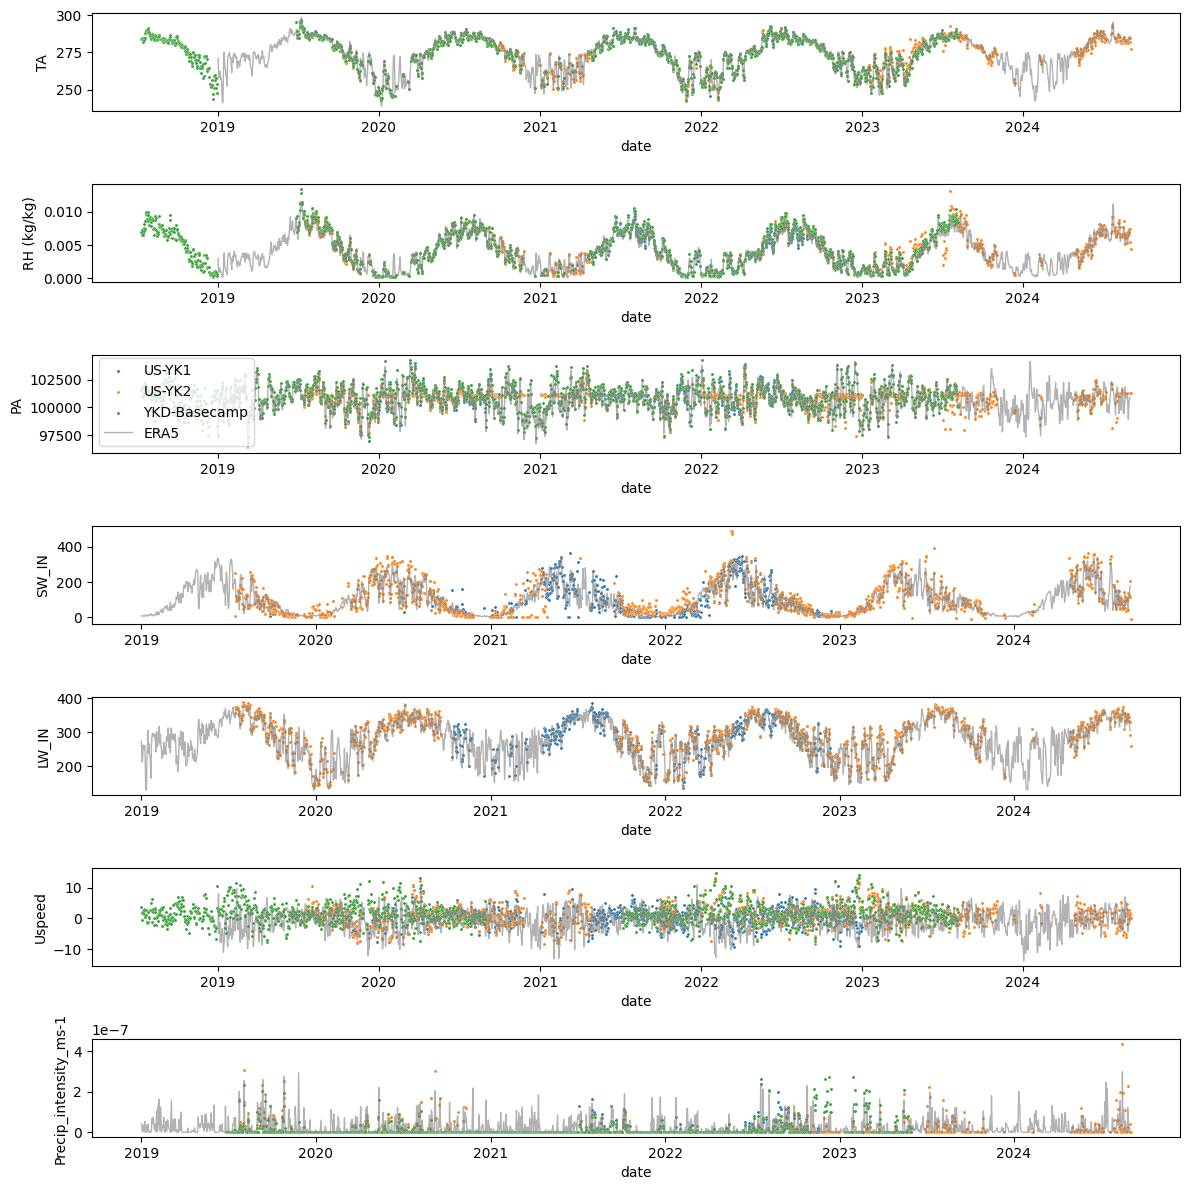

In [436]:
#plot initial data
fig, axes=plt.subplots(7,1, figsize=(12,12))
sns.scatterplot(data=inputs_burned, x='date', y='TA', ax=axes[0], s=5)
sns.scatterplot(data=inputs_unburned, x='date', y='TA', ax=axes[0], s=5)
sns.scatterplot(data=inputs_base, x='date', y='TA', ax=axes[0], s=5)
sns.lineplot(data=df_era5, x='date', y='Temp', ax=axes[0], linewidth=1, color='grey', alpha=0.6)

sns.scatterplot(data=inputs_burned, x='date', y='RH (kg/kg)', ax=axes[1], s=5)
sns.scatterplot(data=inputs_unburned, x='date', y='RH (kg/kg)', ax=axes[1], s=5)
sns.scatterplot(data=inputs_base, x='date', y='RH (kg/kg)', ax=axes[1], s=5)
sns.lineplot(data=df_era5, x='date', y='Hum', ax=axes[1], linewidth=1, color='grey', alpha=0.6)

sns.scatterplot(data=inputs_burned, x='date', y='PA', ax=axes[2], s=5, label='US-YK1')
sns.scatterplot(data=inputs_unburned, x='date', y='PA', ax=axes[2], s=5, label='US-YK2')
sns.scatterplot(data=inputs_base, x='date', y='PA', ax=axes[2], s=5, label='YKD-Basecamp')
sns.lineplot(data=df_era5, x='date', y='Pres', ax=axes[2], linewidth=1, color='grey', alpha=0.6, label='ERA5')


sns.scatterplot(data=inputs_burned, x='date', y='SW_IN', ax=axes[3], s=5)
sns.scatterplot(data=inputs_unburned, x='date', y='SW_IN', ax=axes[3], s=5)
sns.lineplot(data=df_era5, x='date', y='SWdown', ax=axes[3], linewidth=1, color='grey', alpha=0.6)

sns.scatterplot(data=inputs_burned, x='date', y='LW_IN', ax=axes[4], s=5)
sns.scatterplot(data=inputs_unburned, x='date', y='LW_IN', ax=axes[4], s=5)
sns.lineplot(data=df_era5, x='date', y='LWdown', ax=axes[4], linewidth=1, color='grey', alpha=0.6)

sns.scatterplot(data=inputs_burned, x='date', y='Uspeed', ax=axes[5], s=5)
sns.scatterplot(data=inputs_unburned, x='date', y='Uspeed', ax=axes[5], s=5)
sns.scatterplot(data=inputs_base, x='date', y='Uspeed', ax=axes[5], s=5)
sns.lineplot(data=df_era5, x='date', y='Uspeed', ax=axes[5], linewidth=1, color='grey', alpha=0.6)

sns.scatterplot(data=inputs_burned, x='date', y='Precip_intensity_ms-1', ax=axes[6], s=5)
sns.scatterplot(data=inputs_unburned, x='date', y='Precip_intensity_ms-1', ax=axes[6], s=5)
sns.scatterplot(data=inputs_base, x='date', y='Precip_intensity_ms-1', ax=axes[6], s=5)
sns.lineplot(data=df_era5, x='date', y='Precip', ax=axes[6], linewidth=1, color='grey', alpha=0.6)

fig.tight_layout()


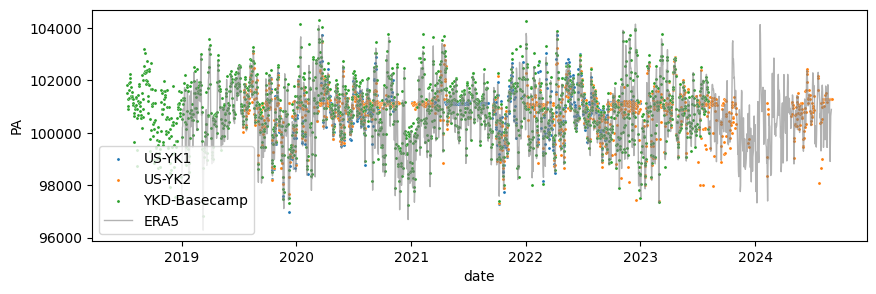

In [437]:
fig, ax = plt.subplots(figsize=(10,3))
sns.scatterplot(data=inputs_burned, x='date', y='PA', s=5, label='US-YK1')
sns.scatterplot(data=inputs_unburned, x='date', y='PA', s=5, label='US-YK2')
sns.scatterplot(data=inputs_base, x='date', y='PA', s=5, label='YKD-Basecamp')
sns.lineplot(data=df_era5, x='date', y='Pres', linewidth=1, color='grey', alpha=0.6, label='ERA5')
plt.savefig('/home/amullen/Lake-Model-Data/data/YKD/in_situ/pressure_comp.jpg', dpi=300)

In [438]:
inputs_base_merged = inputs_base.merge(df_era5[['date']], on='date', how='right')
inputs_burned_merged = inputs_burned.merge(df_era5[['date']], on='date', how='right')
inputs_unburned_merged = inputs_unburned.merge(df_era5[['date']], on='date', how='right')

In [439]:
inputs_unburned_merged['Uspeed'] = -np.nanmean([inputs_unburned_merged['WS'],inputs_burned_merged['WS']], axis=0)*np.cos(np.nanmean([inputs_unburned_merged['WD'],inputs_burned_merged['WD']], axis=0)*pi_180)
inputs_unburned_merged['Vspeed'] = -np.nanmean([inputs_unburned_merged['WS'],inputs_burned_merged['WS']], axis=0)*np.sin(np.nanmean([inputs_unburned_merged['WD'],inputs_burned_merged['WD']], axis=0)*pi_180)

inputs_burned_merged['Uspeed'] = -np.nanmean([inputs_unburned_merged['WS'],inputs_burned_merged['WS']], axis=0)*np.cos(np.nanmean([inputs_unburned_merged['WD'],inputs_burned_merged['WD']], axis=0)*pi_180)
inputs_burned_merged['Vspeed'] = -np.nanmean([inputs_unburned_merged['WS'],inputs_burned_merged['WS']], axis=0)*np.sin(np.nanmean([inputs_unburned_merged['WD'],inputs_burned_merged['WD']], axis=0)*pi_180)

/tmp/ipykernel_14731/2952293387.py:1: RuntimeWarning: Mean of empty slice
  inputs_unburned_merged['Uspeed'] = -np.nanmean([inputs_unburned_merged['WS'],inputs_burned_merged['WS']], axis=0)*np.cos(np.nanmean([inputs_unburned_merged['WD'],inputs_burned_merged['WD']], axis=0)*pi_180)
/tmp/ipykernel_14731/2952293387.py:2: RuntimeWarning: Mean of empty slice
  inputs_unburned_merged['Vspeed'] = -np.nanmean([inputs_unburned_merged['WS'],inputs_burned_merged['WS']], axis=0)*np.sin(np.nanmean([inputs_unburned_merged['WD'],inputs_burned_merged['WD']], axis=0)*pi_180)
/tmp/ipykernel_14731/2952293387.py:4: RuntimeWarning: Mean of empty slice
  inputs_burned_merged['Uspeed'] = -np.nanmean([inputs_unburned_merged['WS'],inputs_burned_merged['WS']], axis=0)*np.cos(np.nanmean([inputs_unburned_merged['WD'],inputs_burned_merged['WD']], axis=0)*pi_180)
/tmp/ipykernel_14731/2952293387.py:5: RuntimeWarning: Mean of empty slice
  inputs_burned_merged['Vspeed'] = -np.nanmean([inputs_unburned_merged['WS'],in

In [440]:
path_to_v1='/home/amullen/LAKE/meteo/YKD-burned-v1.dat'
v1=pd.read_csv(path_to_v1)
v1['date']=pd.to_datetime(v1[['Year', 'Month', 'Day']])
v1 = v1.merge(df_era5[['date']], on='date', how='right')

#fuse data sources for final input dataset
inputs_final = pd.DataFrame(inputs_unburned_merged['date'].copy())

#temperature
inputs_final['Temp'] = np.nanmean([inputs_burned_merged['TA'], inputs_unburned_merged['TA']], axis=0)
inputs_final.loc[np.isnan(inputs_final['Temp']), 'Temp'] = inputs_base_merged.loc[np.isnan(inputs_final['Temp']), 'TA']
inputs_final.loc[np.isnan(inputs_final['Temp']), 'Temp'] = df_era5.loc[np.isnan(inputs_final['Temp']), 'Temp']


#humidity
inputs_final['Hum'] = np.nanmean([inputs_burned_merged['RH (kg/kg)'], inputs_unburned_merged['RH (kg/kg)']], axis=0)
inputs_final.loc[np.isnan(inputs_final['Hum']), 'Hum'] = inputs_base_merged.loc[np.isnan(inputs_final['Hum']), 'RH (kg/kg)']
inputs_final.loc[np.isnan(inputs_final['Hum']), 'Hum'] = df_era5.loc[np.isnan(inputs_final['Hum']), 'Hum']

#air pressure
inputs_final['Pres'] = inputs_base_merged['PA']
inputs_final.loc[np.isnan(inputs_final['Pres']), 'Pres'] = np.nanmean([inputs_burned_merged.loc[np.isnan(inputs_final['Pres']),'PA'], 
                                                                       inputs_unburned_merged.loc[np.isnan(inputs_final['Pres']),'PA']], axis=0)
inputs_final.loc[np.isnan(inputs_final['Pres']), 'Pres'] = df_era5.loc[np.isnan(inputs_final['Pres']),'Pres']

#shortwave
inputs_final['SWdown'] = inputs_burned_merged['SW_IN']
inputs_final.loc[np.isnan(inputs_final['SWdown']), 'SWdown'] = np.nanmean([inputs_unburned_merged.loc[np.isnan(inputs_final['SWdown']),'SW_IN'], 
                                                                       df_era5.loc[np.isnan(inputs_final['SWdown']),'SWdown']], axis=0)
#longwave
inputs_final['LWdown'] = np.nanmean([inputs_burned_merged['LW_IN'], 
                                         inputs_unburned_merged['LW_IN']], axis=0)
inputs_final.loc[np.isnan(inputs_final['LWdown']), 'LWdown'] = df_era5.loc[np.isnan(inputs_final['LWdown']),'LWdown']

#wind speed U
inputs_final['Uspeed'] = np.nanmean([inputs_burned_merged['Uspeed'], inputs_unburned_merged['Uspeed']], axis=0)
inputs_final.loc[np.isnan(inputs_final['Uspeed']), 'Uspeed'] = inputs_base_merged.loc[np.isnan(inputs_final['Uspeed']), 'Uspeed']
inputs_final.loc[np.isnan(inputs_final['Uspeed']), 'Uspeed'] = df_era5.loc[np.isnan(inputs_final['Uspeed']), 'Uspeed']

#wind speed V
inputs_final['Vspeed'] = np.nanmean([inputs_burned_merged['Vspeed'], inputs_unburned_merged['Vspeed']], axis=0)
inputs_final.loc[np.isnan(inputs_final['Vspeed']), 'Vspeed'] = inputs_base_merged.loc[np.isnan(inputs_final['Vspeed']), 'Vspeed']
inputs_final.loc[np.isnan(inputs_final['Vspeed']), 'Vspeed'] = df_era5.loc[np.isnan(inputs_final['Vspeed']), 'Vspeed']

#precipitation
inputs_final['Precip'] = np.nanmean([inputs_burned_merged['Precip_intensity_ms-1'], 
                                     inputs_unburned_merged['Precip_intensity_ms-1']], axis=0)
inputs_final.loc[np.isnan(inputs_final['Precip']), 'Precip'] = df_era5.loc[np.isnan(inputs_final['Precip']), 'Precip']
inputs_final.loc[inputs_final['Temp']<=0, 'Precip'] = df_era5.loc[inputs_final['Temp']<=0, 'Precip']

len(inputs_final)

/tmp/ipykernel_14731/2789484763.py:10: RuntimeWarning: Mean of empty slice
  inputs_final['Temp'] = np.nanmean([inputs_burned_merged['TA'], inputs_unburned_merged['TA']], axis=0)
/tmp/ipykernel_14731/2789484763.py:16: RuntimeWarning: Mean of empty slice
  inputs_final['Hum'] = np.nanmean([inputs_burned_merged['RH (kg/kg)'], inputs_unburned_merged['RH (kg/kg)']], axis=0)
/tmp/ipykernel_14731/2789484763.py:22: RuntimeWarning: Mean of empty slice
  inputs_final.loc[np.isnan(inputs_final['Pres']), 'Pres'] = np.nanmean([inputs_burned_merged.loc[np.isnan(inputs_final['Pres']),'PA'],
/tmp/ipykernel_14731/2789484763.py:31: RuntimeWarning: Mean of empty slice
  inputs_final['LWdown'] = np.nanmean([inputs_burned_merged['LW_IN'],
/tmp/ipykernel_14731/2789484763.py:36: RuntimeWarning: Mean of empty slice
  inputs_final['Uspeed'] = np.nanmean([inputs_burned_merged['Uspeed'], inputs_unburned_merged['Uspeed']], axis=0)
/tmp/ipykernel_14731/2789484763.py:41: RuntimeWarning: Mean of empty slice
  input

2070

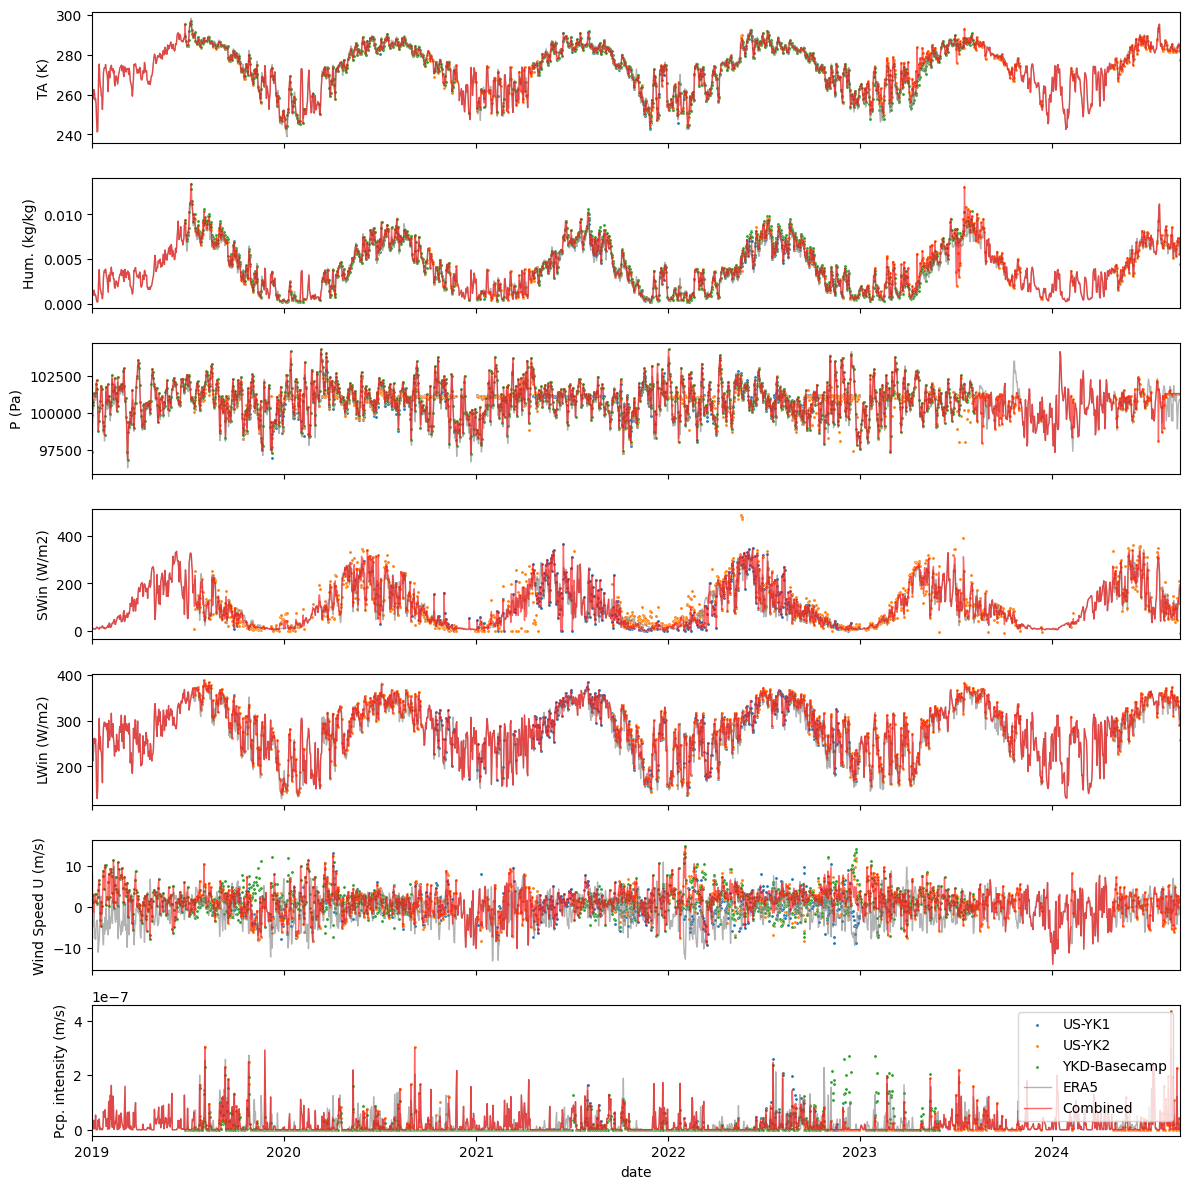

In [441]:
#plot initial data
fig, axes=plt.subplots(7,1, figsize=(12,12), sharex=True)
sns.scatterplot(data=inputs_burned, x='date', y='TA', ax=axes[0], s=5)
sns.scatterplot(data=inputs_unburned, x='date', y='TA', ax=axes[0], s=5)
sns.scatterplot(data=inputs_base, x='date', y='TA', ax=axes[0], s=5)
sns.lineplot(data=df_era5, x='date', y='Temp', ax=axes[0], linewidth=1, color='grey', alpha=0.6)
sns.lineplot(data=inputs_final, x='date', y='Temp', ax=axes[0], linewidth=1, color='red', alpha=0.6)

sns.scatterplot(data=inputs_burned, x='date', y='RH (kg/kg)', ax=axes[1], s=5)
sns.scatterplot(data=inputs_unburned, x='date', y='RH (kg/kg)', ax=axes[1], s=5)
sns.scatterplot(data=inputs_base, x='date', y='RH (kg/kg)', ax=axes[1], s=5)
sns.lineplot(data=df_era5, x='date', y='Hum', ax=axes[1], linewidth=1, color='grey', alpha=0.6)
sns.lineplot(data=inputs_final, x='date', y='Hum', ax=axes[1], linewidth=1, color='red', alpha=0.6)

sns.scatterplot(data=inputs_burned, x='date', y='PA', ax=axes[2], s=5)
sns.scatterplot(data=inputs_unburned, x='date', y='PA', ax=axes[2], s=5)
sns.scatterplot(data=inputs_base, x='date', y='PA', ax=axes[2], s=5)
sns.lineplot(data=df_era5, x='date', y='Pres', ax=axes[2], linewidth=1, color='grey', alpha=0.6)
sns.lineplot(data=inputs_final, x='date', y='Pres', ax=axes[2], linewidth=1, color='red', alpha=0.6)

sns.scatterplot(data=inputs_burned, x='date', y='SW_IN', ax=axes[3], s=5)
sns.scatterplot(data=inputs_unburned, x='date', y='SW_IN', ax=axes[3], s=5)
sns.lineplot(data=df_era5, x='date', y='SWdown', ax=axes[3], linewidth=1, color='grey', alpha=0.6)
sns.lineplot(data=inputs_final, x='date', y='SWdown', ax=axes[3], linewidth=1, color='red', alpha=0.6)

sns.scatterplot(data=inputs_burned, x='date', y='LW_IN', ax=axes[4], s=5)
sns.scatterplot(data=inputs_unburned, x='date', y='LW_IN', ax=axes[4], s=5)
sns.lineplot(data=df_era5, x='date', y='LWdown', ax=axes[4], linewidth=1, color='grey', alpha=0.6)
sns.lineplot(data=inputs_final, x='date', y='LWdown', ax=axes[4], linewidth=1, color='red', alpha=0.6)

sns.scatterplot(data=inputs_burned, x='date', y='Uspeed', ax=axes[5], s=5)
sns.scatterplot(data=inputs_unburned, x='date', y='Uspeed', ax=axes[5], s=5)
sns.scatterplot(data=inputs_base, x='date', y='Uspeed', ax=axes[5], s=5)
sns.lineplot(data=df_era5, x='date', y='Uspeed', ax=axes[5], linewidth=1, color='grey', alpha=0.6)
sns.lineplot(data=inputs_final, x='date', y='Uspeed', ax=axes[5], linewidth=1, color='red', alpha=0.6)

sns.scatterplot(data=inputs_burned, x='date', y='Precip_intensity_ms-1', ax=axes[6], s=5, label='US-YK1')
sns.scatterplot(data=inputs_unburned, x='date', y='Precip_intensity_ms-1', ax=axes[6], s=5, label='US-YK2')
sns.scatterplot(data=inputs_base, x='date', y='Precip_intensity_ms-1', ax=axes[6], s=5, label='YKD-Basecamp')
sns.lineplot(data=df_era5, x='date', y='Precip', ax=axes[6], linewidth=1, color='grey', alpha=0.6, label='ERA5')
sns.lineplot(data=inputs_final, x='date', y='Precip', ax=axes[6], linewidth=1, color='red', alpha=0.6, label='Combined')

plt.xlim(pd.to_datetime('2019-01-01'), pd.to_datetime('2024-09-01'))
axes[0].set_ylabel('TA (K)')
axes[1].set_ylabel('Hum. (kg/kg)')
axes[2].set_ylabel('P (Pa)')
axes[3].set_ylabel('SWin (W/m2)')
axes[4].set_ylabel('LWin (W/m2)')
axes[5].set_ylabel('Wind Speed U (m/s)')
axes[6].set_ylabel('Pcp. intensity (m/s)')
fig.tight_layout()

plt.savefig('/home/amullen/Lake-Model-Data/data/YKD/figs/YKD_ins_2019-2024.jpg', dpi=300)


In [442]:
inputs_final['Year'] = inputs_final['date'].dt.year
inputs_final['Month'] = inputs_final['date'].dt.month
inputs_final['Day'] = inputs_final['date'].dt.day


inputs_final.loc[inputs_final['date']>=pd.to_datetime('2019-07-01'),
                 ['Year','Month','Day','Uspeed','Vspeed',
              'Temp','Hum','Pres','SWdown','LWdown','Precip']].to_csv('/home/amullen/Lake-Model-Data/data/YKD/LAKE/ponds_2019-2024/YKD-burned.dat', index=False)
inputs_final.loc[inputs_final['date']>=pd.to_datetime('2019-07-01'),
                 ['Year','Month','Day','Uspeed','Vspeed',
              'Temp','Hum','Pres','SWdown','LWdown','Precip']].to_csv('/home/amullen/Lake-Model-Data/data/YKD/LAKE/ponds_2019-2024/YKD-unburned.dat', index=False)


inputs_final.loc[inputs_final['date']>=pd.to_datetime('2019-07-01'),
                 ['Year','Month','Day','Uspeed','Vspeed',
              'Temp','Hum','Pres','SWdown','LWdown','Precip']].to_csv('/home/amullen/LAKE/meteo/YKD-unburned.dat', index=False)
inputs_final.loc[inputs_final['date']>=pd.to_datetime('2019-07-01'),
                 ['Year','Month','Day','Uspeed','Vspeed',
              'Temp','Hum','Pres','SWdown','LWdown','Precip']].to_csv('/home/amullen/LAKE/data/YKD-unburned.dat', index=False)

inputs_final.loc[inputs_final['date']>=pd.to_datetime('2019-07-01'),
                 ['Year','Month','Day','Uspeed','Vspeed',
              'Temp','Hum','Pres','SWdown','LWdown','Precip']].to_csv('/home/amullen/LAKE/meteo/YKD-burned.dat', index=False)
inputs_final.loc[inputs_final['date']>=pd.to_datetime('2019-07-01'),
                 ['Year','Month','Day','Uspeed','Vspeed',
              'Temp','Hum','Pres','SWdown','LWdown','Precip']].to_csv('/home/amullen/LAKE/data/YKD-burned.dat', index=False)

In [443]:
len(inputs_final.loc[inputs_final['date']>=pd.to_datetime('2019-07-01')])

1889